# Activation patching basic


In [1]:

%load_ext autoreload
%autoreload 2
# # # set cuda visible device
# !export CUDA_VISIBLE_DEVICES=3
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

starcoderbase_1b = "/home/arjun/models/starcoderbase-1b/"

from nnsight import LanguageModel
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from src.utils import *
import datasets
from src.experiments.wrong_type_patching import *
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
import plotly.express as px

from nnsight import LanguageModel, util
from nnsight.tracing.Proxy import Proxy

import datasets
from src.utils import *

In [2]:
model = LanguageModel(starcoderbase_1b, device_map='cuda:3')
model

GPTBigCodeForCausalLM(
  (transformer): GPTBigCodeModel(
    (wte): Embedding(49152, 2048)
    (wpe): Embedding(8192, 2048)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTBigCodeBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTBigCodeSdpaAttention(
          (c_attn): Linear(in_features=2048, out_features=2304, bias=True)
          (c_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTBigCodeMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj): Linear(in_features=8192, out_features=2048, bias=True)
          (act): PytorchGELUTanh()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((2048,), ep

## Activation patching

In [3]:
ds = datasets.load_dataset("franlucc/type_patching_v0", split="train")
string_ex = [d for d in ds if d["fim_type"] == "string"]
boolean_ex = [d for d in ds if d["fim_type"] == "boolean"]
number_ex = [d for d in ds if d["fim_type"] == "number"]

string_idx = model.tokenizer.convert_tokens_to_ids("string")
boolean_idx = model.tokenizer.convert_tokens_to_ids("boolean")
number_idx = model.tokenizer.convert_tokens_to_ids("number")
print(string_idx, boolean_idx, number_idx)



800 4398 2171


In [4]:
# import os
# os.makedirs("str-bool-num-types",exist_ok=True)
# os.makedirs("str-bool-num-types/str",exist_ok=True)
# os.makedirs("str-bool-num-types/bool",exist_ok=True)
# os.makedirs("str-bool-num-types/num",exist_ok=True)
# for i,prog in enumerate(string_ex):
#     with open(f"str-bool-num-types/str/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
# for i,prog in enumerate(boolean_ex):
#     with open(f"str-bool-num-types/bool/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
# for i,prog in enumerate(number_ex):
#     with open(f"str-bool-num-types/num/{i}_prog.ts", "w") as f:
#         f.write(str(prog["fim_program"]))
        
    

In [5]:
from src.experiments.type_patching import *
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pred_results = []
probs_patched_results = []
earliest_layer = []
def get_ds(patch):
    if patch == "string":
        return string_ex
    elif patch == "boolean":
        return boolean_ex
    elif patch == "number":
        return number_ex

patch_src = "string"
patch_dst = "number"
correct_index = model.tokenizer(patch_src)["input_ids"][0]
incorrect_index = model.tokenizer(patch_dst)["input_ids"][0]

import random
# 10 random idx
random.seed(36)
idx_range = [random.randint(0, 500) for i in range(5)]
layers = list(range(13,16))

for i in idx_range:
    with torch.no_grad():
        torch.cuda.empty_cache()
    clean_prompt = placeholder_to_std_fmt(get_ds(patch_src)[i]["fim_program"], STARCODER_FIM)
    corrupted_prompt = placeholder_to_std_fmt(get_ds(patch_dst)[i]["fim_program"], STARCODER_FIM)
    patching_results, patched_predictions = patch_fim_tokens(model, clean_prompt, corrupted_prompt, STARCODER_FIM, correct_index, incorrect_index, layers)
    
    patched_predictions = util.apply(patched_predictions, lambda x: x.value.item(), Proxy)
    patching_results = util.apply(patching_results, lambda x: x.value.item(), Proxy)
    
    probs_patched_results.append(patching_results)
    pred_results.append(patched_predictions)
    
    idx = [j for j, x in enumerate(patched_predictions) if x == correct_index]
    if len(idx) == 0:
        idx = [-1]
    earliest_layer.append(idx[0])

    # clear gpu memory
    with torch.no_grad():
        torch.cuda.empty_cache()

Patching...


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Patching...


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


[800, 2171]


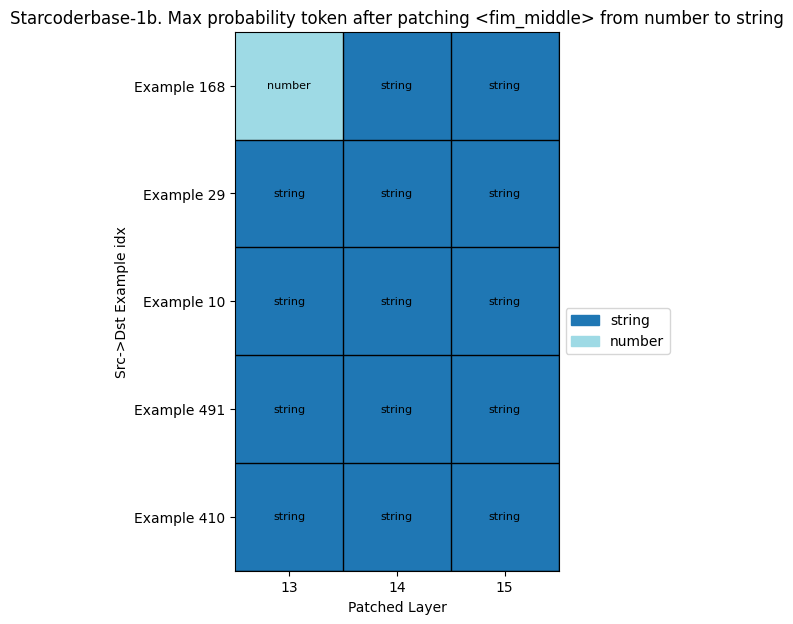

({0: {'pred': 2171, 'string': '0.20', 'number': '0.79', 'boolean': '0.00'},
  1: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  2: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  3: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  4: {'pred': 800, 'string': '0.93', 'number': '0.01', 'boolean': '0.00'},
  5: {'pred': 800, 'string': '0.79', 'number': '0.15', 'boolean': '0.00'},
  6: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  7: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  8: {'pred': 800, 'string': '0.99', 'number': '0.00', 'boolean': '0.00'},
  9: {'pred': 800, 'string': '0.88', 'number': '0.01', 'boolean': '0.00'},
  10: {'pred': 800, 'string': '0.89', 'number': '0.07', 'boolean': '0.00'},
  11: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  12: {'pred': 800, 'string': '1.00', 'number': '0.00', 'boolean': '0.00'},
  13: {'pred': 800, '

In [6]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# import numpy as np
# colours = im.cmap(im.norm(np.unique(pred_results)))
# len_colors = len(colours)

plt.figure(figsize=(7,7))

# make labels
flat_results = [x for y in pred_results for x in y]
labels = set([model.tokenizer.decode([x]) for x in flat_results])
labels = list(set(flat_results))
labels.sort()
print(labels)


# set color map
im = plt.imshow(pred_results, norm="log", cmap="tab20")

plt.yticks(range(len(pred_results)), [f"Example {i}" for i in idx_range])
plt.xticks(range(len(layers)), layers)
plt.xlabel("Patched Layer")
plt.ylabel("Src->Dst Example idx")
plt.title(f"Starcoderbase-1b. Max probability token after patching <fim_middle> from {patch_dst} to {patch_src}")

# make legend

# get map of labels to colors from image
color_map = im.cmap(im.norm(np.unique(pred_results)))
# use map to make legend
plt.legend(loc="upper left", bbox_to_anchor=(1,0.5), handles=[plt.Rectangle((0,0),1,1, color=color_map[i], label=model.tokenizer.decode(labels[i])) for i in range(len(labels))])


# add grid between examples and layers (halfway!)
plt.hlines([i+0.5 for i in range(len(pred_results))], *plt.xlim(), color="black", linewidth=1)
plt.vlines([i+0.5 for i in range(len(layers))], *plt.ylim(), color="black", linewidth=1)


# build an annotations dict for each square in grid with values from probs_patched_results
annotations = {i:{} for i in range(len(layers)*len(pred_results))}

for i in range(len(pred_results)):
    for j in range(len(layers)):
        probs = probs_patched_results[i][j]
        str_probs = probs[0]
        num_probs = probs[1]
        bool_probs = probs[2]
        annotations[i+len(pred_results)*j] = {"pred": pred_results[i][j],"string": f"{str_probs:.2f}", "number": f"{num_probs:.2f}", "boolean": f"{bool_probs:.2f}"}
        
# create tuples of positions
positions =[(x , y ) for x in range(len(layers)) for y in range(len(pred_results))]

# add annotations
for pos, text in annotations.items():
    plt.annotate(model.tokenizer.decode(text["pred"]), xy=positions[pos],color="black", fontsize=8, ha="center", va="center")
#     plt.annotate(text["string"], xy=positions[pos], ha="left", va="bottom", color="black")
#     plt.annotate(text["number"], xy=positions[pos], ha="center", va="center", color="black")
#     plt.annotate(text["boolean"], xy=positions[pos], ha="right", va="top", color="black") 

range_str = '-'.join([str(i) for i in idx_range])
# plt.savefig(f"results/starcoderbase-1b_patch-{patch_dst}-to-{patch_src}_idx-{range_str}_layers-{layers[0]}-{layers[-1]}.pdf", bbox_inches="tight")

plt.show()
annotations, pred_results

## Correct wrong predictions

In [4]:
model = AutoModelForCausalLM.from_pretrained(starcoderbase_1b).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(starcoderbase_1b)


In [79]:
ds = make_dataset(model, tokenizer)

100%|██████████| 300/300 [01:45<00:00,  2.83it/s]


In [80]:
num_success = len(ds.filter(lambda x: x["success"] == True))
num_fail = len(ds.filter(lambda x: x["success"] == False))
print(f"Success: {num_success}, Fail: {num_fail}")
ds.push_to_hub("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", private=True)

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Success: 163, Fail: 137


## Patching over layer 14

Experiment: 

1. take all the working prompts, average activations of <fim_middle> at layer 14

2. for all the bad prompts, patch them with the average activation of <fim_middle> at layer 14

In [84]:

ds = datasets.load_dataset("franlucc/starcoderbase-1b-wrong-type-patching-v0-seed42", split="train")
working_ds = ds.filter(lambda x: x["success"] == True)
working_prompts = []
for i in range(len(working_ds)):
    working_prompts.append(working_ds[i]["prompt"])

model = LanguageModel(starcoderbase_1b, device_map='cuda:3')
model.config.use_cache = False
activations = get_avg_activations(model, working_prompts, 12, -1, STARCODER_FIM)
avg_activ = util.apply(activations, lambda x: x.value, Proxy)

In [4]:
model.config.use_cache

False

In [5]:
avg_activ

tensor([[-0.0058, -0.6299,  0.9661,  ...,  0.4257,  0.1548, -0.3455]],
       device='cuda:3')

In [6]:
broken_ds = ds.filter(lambda x: x["success"] == False)
broken_prompts = []
solutions = []
for i in range(len(broken_ds)):
    broken_prompts.append(broken_ds[i]["prompt"])
    solutions.append(broken_ds[i]["solution"])


In [81]:
model.config.use_cache = False
res = perform_patch(model, broken_prompts[:5], solutions[:5], list(range(13,15)), -1, avg_activ, STARCODER_FIM)

0it [00:00, ?it/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
1it [00:02,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
2it [00:06,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Sett

In [82]:
for r in res:
    r["generated"] = util.apply(r["generated"], lambda x: x.value, Proxy)

In [83]:
for i in range(len(res)):
      print(f"====================\nExample {i}\n====================")
      l = res[i]["generated"].cpu().numpy().tolist()
      print("".join([model.tokenizer.decode(j) for j in l[0][-6:]]), "\n\nSolution:\n",
            res[i]["solution"], "\n\nOld generated:\n",
            broken_ds[i]["generated"])

Example 0
<fim_middle>_uniq_1) 

Solution:
 _uniq_0 

Old generated:
 _uniq_1) => _uniq_0,
  _uniq_11: _uniq_0
): _uniq_0 {
  switch (_uniq_9.kind) {
    case "Ctor4": {
      return _uniq
Example 1
<fim_middle>nat) => nat) 

Solution:
 nat 

Old generated:
 nat) => nat) {
    switch (l.kind) {
      case "Nil": {
        return { kind: "Nil" };
      }
      case "Cons": {
        let xs = l.f1;
        let x =
Example 2
<fim_middle>_uniq_0): 

Solution:
 _uniq_3 

Old generated:
 _uniq_0): _uniq_1 {
  switch (_uniq_23.kind) {
    case "Ctor4": {
      return { kind: "Ctor6" };
    }
    case "Ctor5": {
      let _
Example 3
<fim_middle>_uniq_1<|endoftext|> 

Solution:
 _uniq_2 

Old generated:
 _uniq_1): _uniq_2 {
  switch (_uniq_35.kind) {
    case "Ctor6": {
      return { kind: "Ctor8" };
    }
    case "Ctor7": {
      let _
Example 4
<fim_middle>_uniq_1): 

Solution:
 _uniq_2 

Old generated:
 _uniq_1): _uniq_2 {
  switch (_uniq_14.kind) {
    case "Ctor5": {
      return { kind